In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os

In [2]:

# 定义一个自定义的数据集类
class HandwrittenDigitsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        :param root_dir: 包含多个子文件夹的根目录，每个子文件夹的名称是标签
        :param transform: 图像的转换操作
        """
        self.transform = transform
        self.samples = []
        # 遍历根目录下的每个子文件夹
        for label in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, label)
            if os.path.isdir(folder_path):
                # 遍历子文件夹中的每个文件
                for file in os.listdir(folder_path):
                    if file.endswith('.npy'):
                        self.samples.append((os.path.join(folder_path, file), int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        # 加载 .npy 文件
        image = np.load(file_path)
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
# 定义转换操作
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 创建数据集实例
dataset = HandwrittenDigitsDataset('./processed_data/train/', transform=transform)

# 创建数据加载器
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 使用数据加载器在 PyTorch 模型中进行训练
# 示例模型和训练代码将取决于具体的模型架构和训练细节

In [16]:
# 创建数据集实例
test_set = HandwrittenDigitsDataset('./processed_data/test/', transform=transform)

# 创建数据加载器
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [17]:
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import os
from PIL import Image
import numpy as np

# 预处理：将两个步骤整合在一起
transform = transforms.Compose({
    transforms.ToTensor(), # 转为Tensor，范围改为0-1
    transforms.Normalize((0.1307,),(0.3081)) # 数据归一化，即均值为0，标准差为1
})

# 训练数据集
train_data = dataset
train_loader = dataloader
# 模型
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,64)
        self.linear3 = nn.Linear(64,10) # 10个手写数字对应的10个输出

    def forward(self,x):
        x = x.view(-1,784) # 变形
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))
        return x

# CrossEntropyLoss
model = Model()
criterion = nn.CrossEntropyLoss() # 交叉熵损失，相当于Softmax+Log+NllLoss
optimizer = torch.optim.SGD(model.parameters(),0.8) # 第一个参数是初始化参数值，第二个参数是学习率

# 模型训练
def train():
    for index,data in enumerate(train_loader):
        input,target = data # input为输入数据，target为标签
        optimizer.zero_grad() # 梯度清零
        y_predict = model(input) # 模型预测
        loss = criterion(y_predict,target) # 计算损失
        loss.backward() # 反向传播
        optimizer.step() # 更新参数
        if index % 100 == 0: # 每一百次保存一次模型，打印损失
            torch.save(model.state_dict(),"./model/model.pkl") # 保存模型
            torch.save(optimizer.state_dict(),"./model/optimizer.pkl")
            print("损失值为：%.2f" % loss.item())

此手写图片值为:1,其最大概率为:0.24


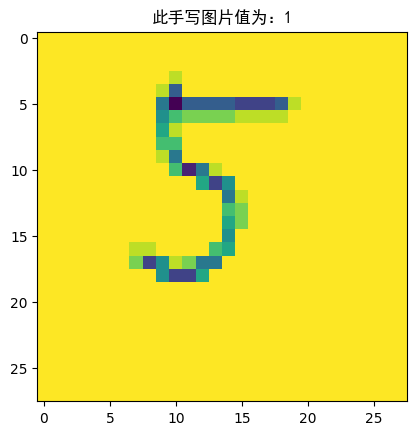

ValueError: Expected input batch_size (320) to match target batch_size (32).

In [20]:

# 加载模型
if os.path.exists('./model/model.pkl'):
    model.load_state_dict(torch.load("./model/model.pkl")) # 加载保存模型的参数

# 模型测试
def test():
    correct = 0 # 正确预测的个数
    total = 0 # 总数
    with torch.no_grad(): # 测试不用计算梯度
        for data in test_loader:
            input,target = data
            output=model(input) # output输出10个预测取值，其中最大的即为预测的数
            probability,predict=torch.max(output.data,dim=1) # 返回一个元组，第一个为最大概率值，第二个为最大值的下标
            total += target.size(0) # target是形状为(batch_size,1)的矩阵，使用size(0)取出该批的大小
            correct += (predict == target).sum().item() # predict和target均为(batch_size,1)的矩阵，sum()求出相等的个数
        print("准确率为：%.2f" % (correct / total))

# 自定义手写数字识别测试
def test_mydata():
    image = Image.open('5.png') # 读取自定义手写图片
    image = image.resize((28,28)) # 裁剪尺寸为28*28
    image = image.convert('L') # 转换为灰度图像
    transform = transforms.ToTensor()
    image = transform(image)
    image = image.resize(1,1,28,28)
    output = model(image)
    probability,predict=torch.max(output.data,dim=1)
    print("此手写图片值为:%d,其最大概率为:%.2f" % (predict[0],probability))
    plt.title('此手写图片值为：{}'.format((int(predict))),fontname="SimHei")
    plt.imshow(image.squeeze())
    plt.show()

# 主函数
if __name__ == '__main__':
    # 自定义测试
    test_mydata()
    # 训练与测试
    for i in range(5): # 训练和测试进行两轮
        train()
        test()


100%|██████████| 9912422/9912422 [00:00<00:00, 17856788.75it/s]


Extracting ./mnist/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 2933138.67it/s]


Extracting ./mnist/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 18932812.64it/s]


Extracting ./mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist/MNIST\raw

torch.Size([60000, 28, 28])
torch.Size([60000])



C:\Users\20230921a\.conda\envs\pytorch\Lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\20230921a\.conda\envs\pytorch\Lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


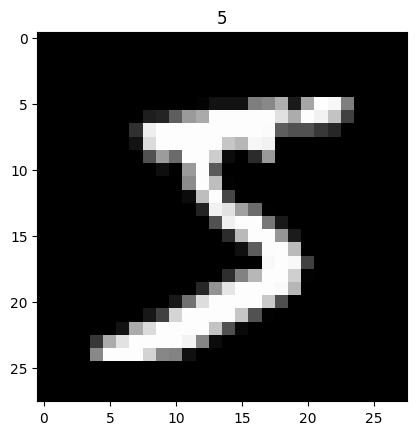

C:\Users\20230921a\.conda\envs\pytorch\Lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\20230921a\.conda\envs\pytorch\Lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2909 | test accuracy: 0.10


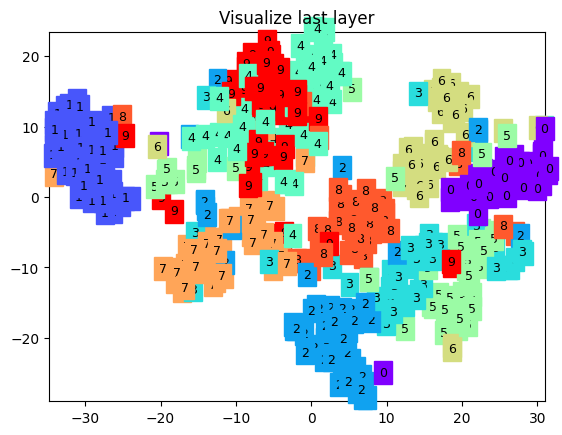

Epoch:  0 | train loss: 0.4731 | test accuracy: 0.82


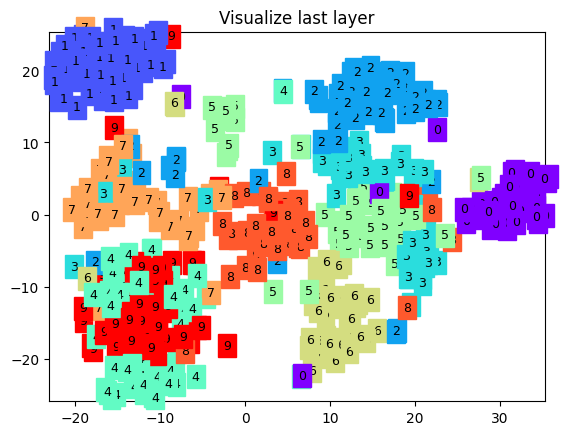

Epoch:  0 | train loss: 0.2384 | test accuracy: 0.91


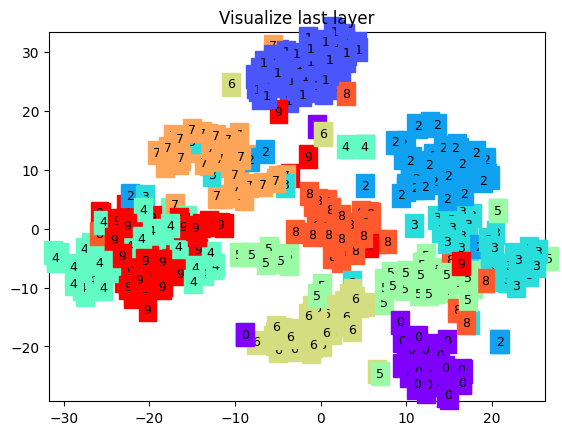

Epoch:  0 | train loss: 0.2892 | test accuracy: 0.91


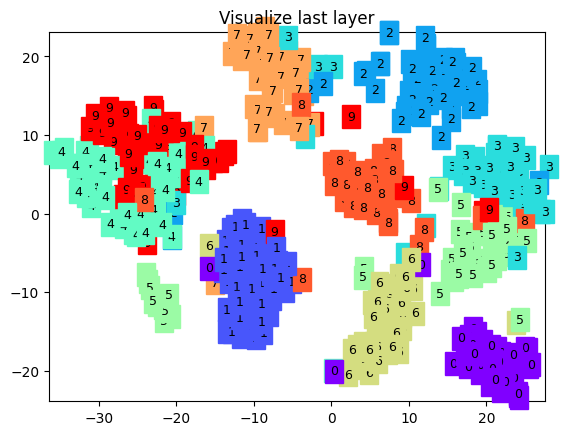

Epoch:  0 | train loss: 0.0850 | test accuracy: 0.94


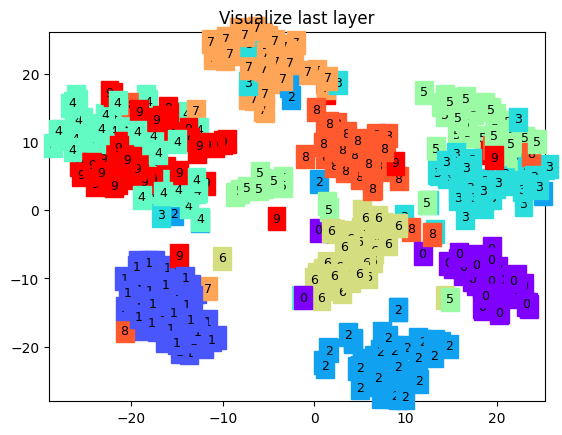

Epoch:  0 | train loss: 0.1245 | test accuracy: 0.94


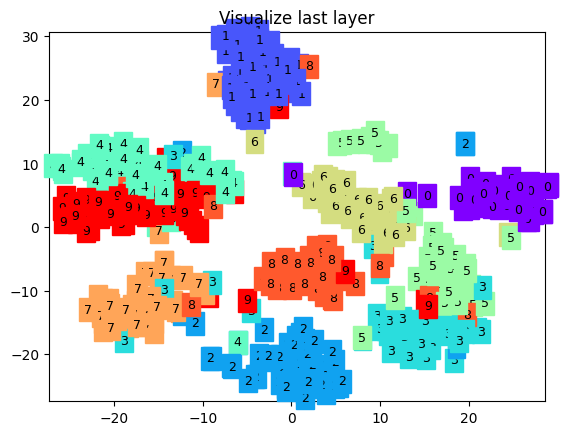

Epoch:  0 | train loss: 0.1419 | test accuracy: 0.95


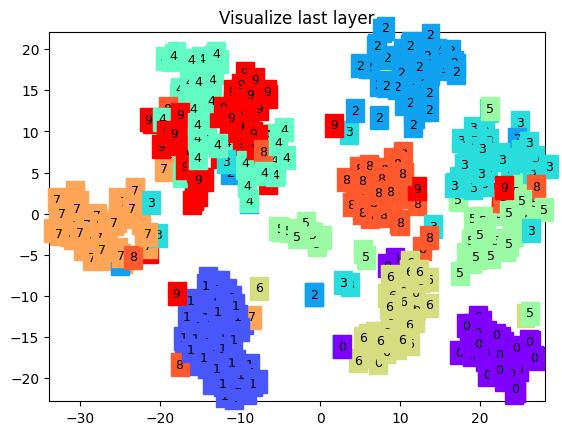

Epoch:  0 | train loss: 0.1512 | test accuracy: 0.95


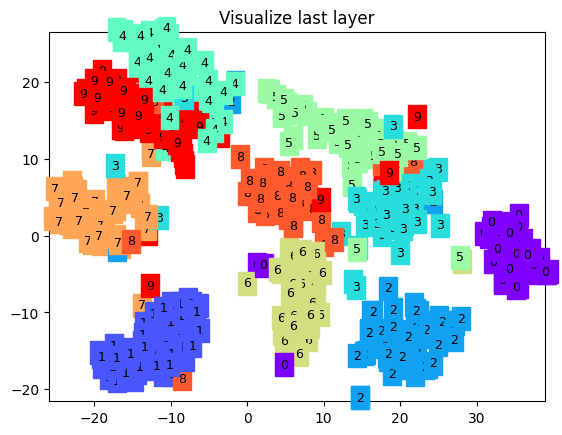

Epoch:  0 | train loss: 0.0945 | test accuracy: 0.95


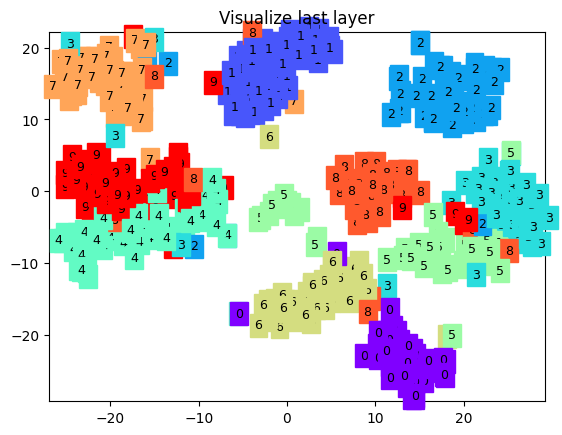

Epoch:  0 | train loss: 0.0865 | test accuracy: 0.97


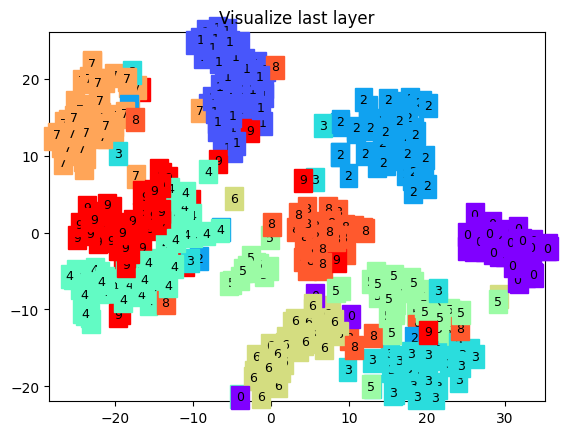

Epoch:  0 | train loss: 0.1673 | test accuracy: 0.96


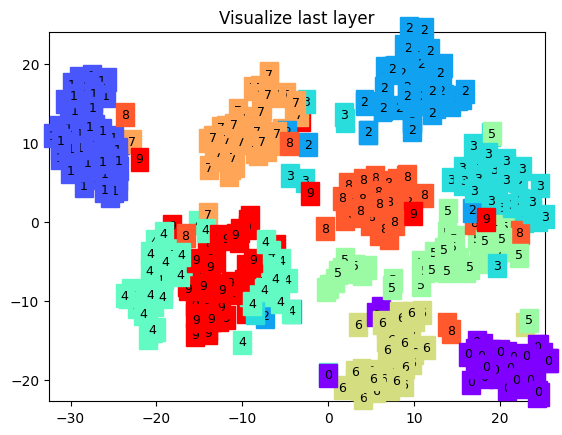

Epoch:  0 | train loss: 0.1044 | test accuracy: 0.96


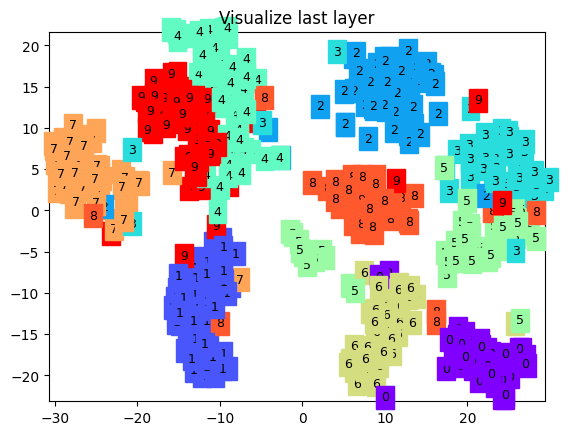

Epoch:  0 | train loss: 0.0591 | test accuracy: 0.96


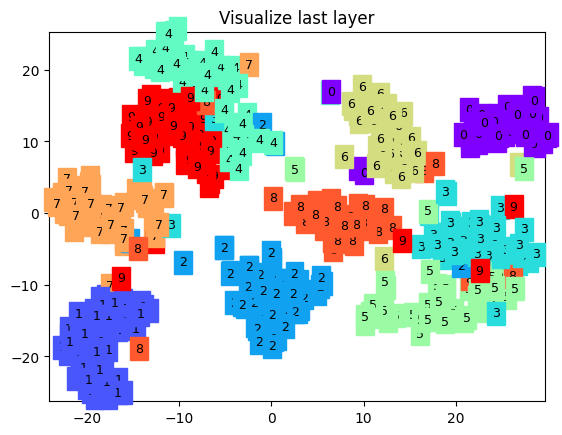

Epoch:  0 | train loss: 0.1592 | test accuracy: 0.97


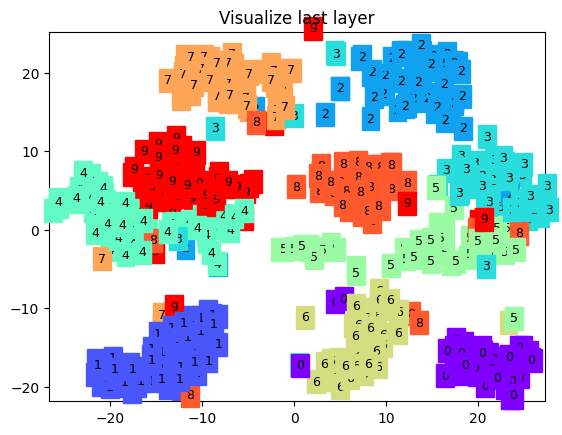

Epoch:  0 | train loss: 0.0176 | test accuracy: 0.97


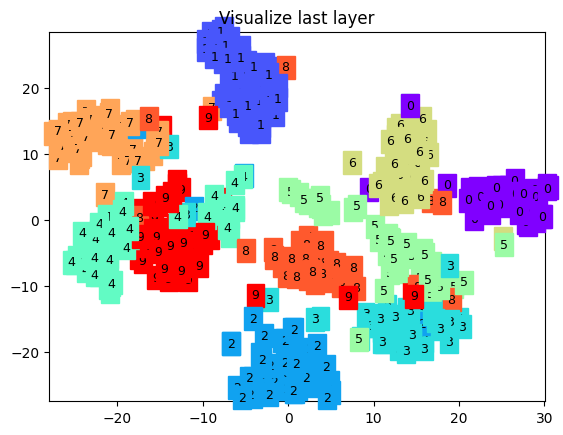

Epoch:  0 | train loss: 0.0142 | test accuracy: 0.97


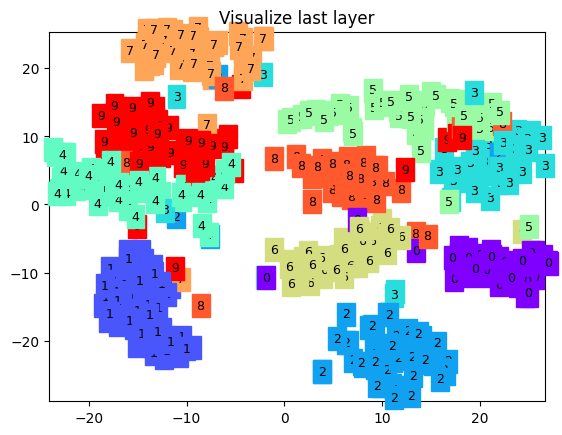

Epoch:  0 | train loss: 0.0558 | test accuracy: 0.97


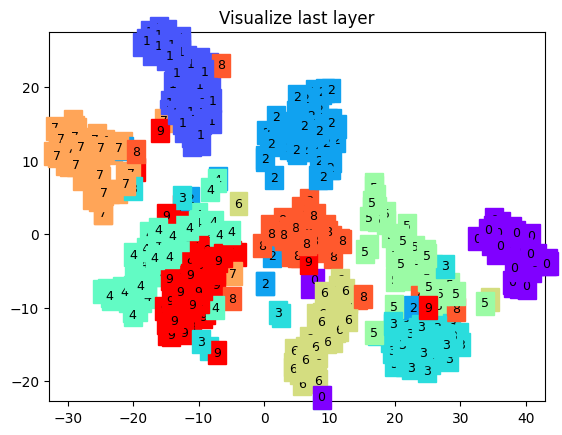

Epoch:  0 | train loss: 0.0941 | test accuracy: 0.97


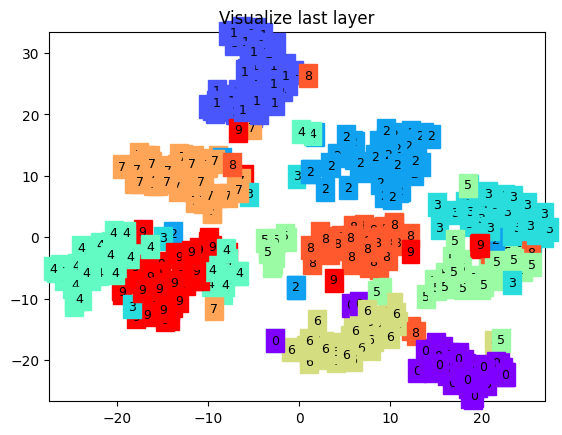

Epoch:  0 | train loss: 0.0146 | test accuracy: 0.97


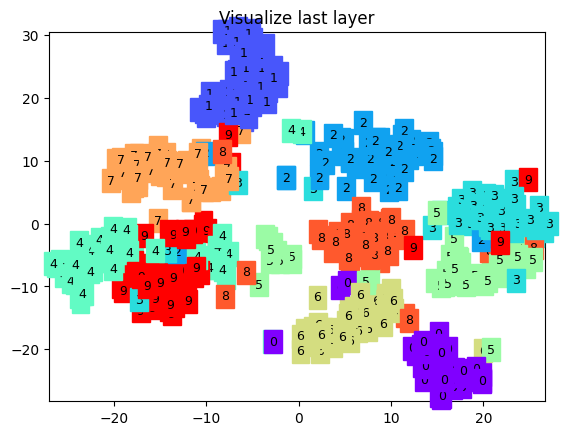

Epoch:  0 | train loss: 0.0336 | test accuracy: 0.97


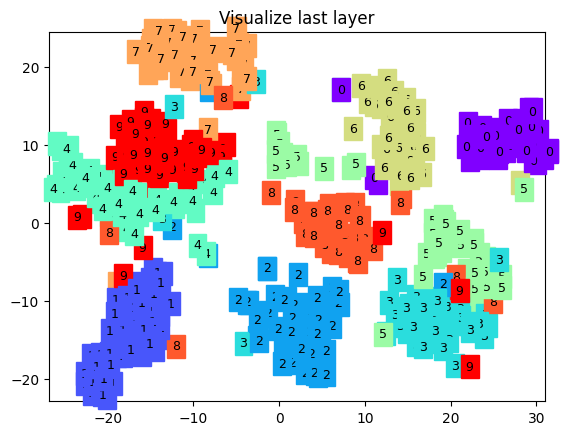

Epoch:  0 | train loss: 0.0122 | test accuracy: 0.97


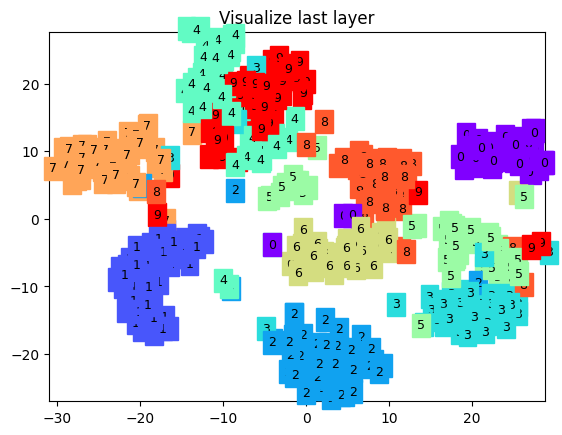

Epoch:  0 | train loss: 0.1852 | test accuracy: 0.97


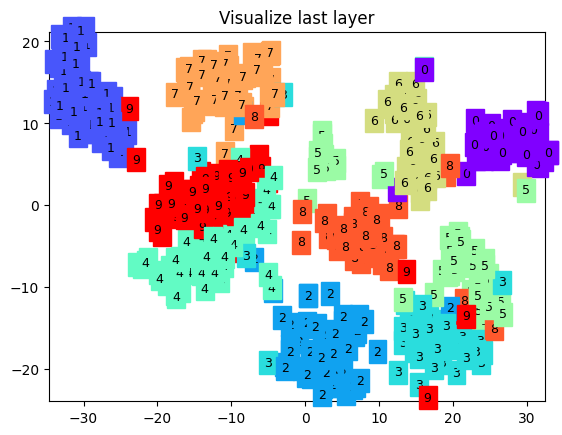

Epoch:  0 | train loss: 0.0918 | test accuracy: 0.97


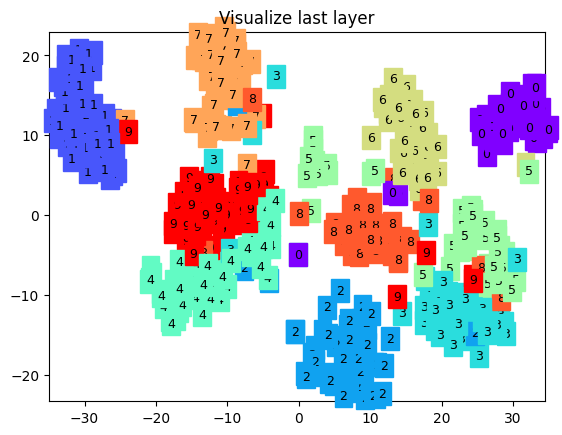

Epoch:  0 | train loss: 0.0743 | test accuracy: 0.98


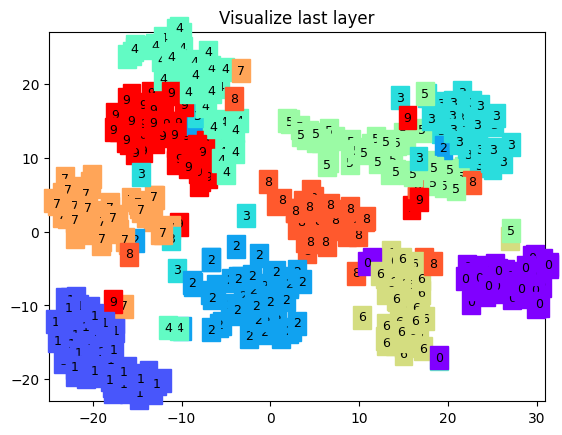

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [21]:
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False


# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization


cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')